# Figure 8: Known and Unknown background

In [1]:
from functools import partial
import gzip
import pickle
from pathlib import Path
import time
from concurrent.futures import ProcessPoolExecutor, as_completed

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["text.usetex"] =  True

import hypney.all as hp
from common import draw_limits, sketch_dist, log_x

def powerlaw(similarity, mu, loc=0):
    if similarity < 0:
        # Flip side
        return powerlaw(-similarity, mu, loc=-1).scale(-1)
    return hp.powerlaw(a=1/similarity, rate=mu, loc=loc)

mu_signal = hp.DEFAULT_RATE_GRID
signal = hp.uniform().fix_except('rate')
known_bg = powerlaw(0.5, 20).freeze()

mu_signal_clip = mu_signal[mu_signal < 110][1:]
# mu_signal_clip

In [2]:
#cmap = plt.cm.viridis

regions, suffix = hp.uniform_sn_cuts(5), ''
#regions, suffix = np.asarray([(0., 0.2), (0., 0.4), (0., 0.6), (0., 0.8), (0., 1.)]), '_l5'

statistics = dict(
    full_lr=dict(
        stat=hp.SignedPLR(signal + known_bg
                         ).with_stored_dist('full_lr_fullspace_powerlaw_0.5_20'),
        color='k',
        label="$t$, Full space",
        n_toy_limits=200,
    ),
        
    s5_lr=dict(
        # 1000 toys took over three hours, with paralellization!
        # so paralellized statistic operates at ~ 152k toys ~ 12k sec, i.e. ~13 toys/sec
        stat=hp.FixedRegionFullHawk(
            signal + known_bg, 
            cuts=regions,
            signal_only=False,
            ).with_stored_dist('full_lr_s5_powerlaw_0.5_20' + suffix, n_toys=1000),
        label="$H[t, S_5]$",
        color='b',
        #color=cmap(1.),
        n_toy_limits=200,
    ),
    
    lr0_all=dict(
        stat=hp.AllRegionSimpleHawk(
            signal + known_bg,  
            signal_only=False)
            .with_stored_dist('lr_all' + suffix),
        label="$H[t_0, I]$, combined model",
        color='purple',
        #color=cmap(1/3),
        n_toy_limits=2000,
    ),
    
    lr0_all_sigmu=dict(
        # Calculate statistic while ignoring background ...
        stat=hp.AllRegionSimpleHawk(
            signal, 
            signal_only=True,
            # ... but account for it in the critical value
            ).with_stored_dist('lr_sigmu_all_plaw0.5_20' + suffix,
                               simulate_from_model=signal + known_bg),
        label=r"$H[t_0, I]$, adusted critical value",
        color='g',
        #color=cmap(2/3),
        n_toy_limits=2000,
    ),

    lr0_all_ignore_bg=dict(
        stat=hp.AllRegionSimpleHawk(
            signal,
            signal_only=True)
            .with_stored_dist('lr_all' + suffix),
        label="$H[t_0, I]$, ignoring the known background",
        color='r',
        #color=cmap(0.),
        n_toy_limits=2000,
    ),
    
#     z_s5=dict(
#         stat=hp.ZFixedRegionHawk(
#             signal + known_bg,
#             cuts=regions,
#             signal_only=False,
#             ).with_stored_dist('z_allmu_s5_plaw0.5_20' + suffix),
#         label="$z$, $S_5$, all $\mu$",
#         color='magenta',
#         #color=cmap(2/3),
#         n_toy_limits=2000,
#     ),
#     zy_s5=dict(
#         stat=hp.ZYFixedRegionHawk(
#             signal + known_bg,
#             cuts=hp.uniform_sn_cuts(5),
#             signal_only=False,
#             ).with_stored_dist('zy_allmu_s5_plaw0.5_20'),
#         label="$zy$, $S_5$, all $\mu$",
#         color='cyan',
#         #color=cmap(2/3),
#         n_toy_limits=2000,
#     ),

    # PN is very similar to t0
#     pn_s5=dict(
#         stat=hp.PNFixedRegionHawk(signal + known_bg,  cuts=hp.uniform_sn_cuts(5)).with_stored_dist('pn_s5'),
#         #stat=hp.PNAllRegionHawk(signal + known_bg).with_stored_dist('pn_all'),
#         label="PN, $S_5$",
#         #color='papayawhip',
#         color='g',
#         n_toy_limits=2000,
#     ),
    
    # Gaps is truly horrible
#     gaps=dict(
#         stat=hp.AllRegionSimpleHawk(signal + known_bg, n_max=0).with_stored_dist('lr_gaps'),
#         #stat=hp.PNAllRegionHawk(signal + known_bg).with_stored_dist('pn_all'),
#         label="Max. gap",
#         color='pink',
#         #alpha=0.5
#         n_toy_limits=2000,
#     ),
    
#     cn_all=dict(
#         stat=hp.YellinCNHawk(signal + known_bg).with_stored_dist('yellin_cn_149max', rate_anchors=mu_signal_clip),
#         label="CN (all regions)",
#         color='pink',
#         n_toy_limits=200,
#         limit_anchors=mu_signal_clip,
#     ),
)

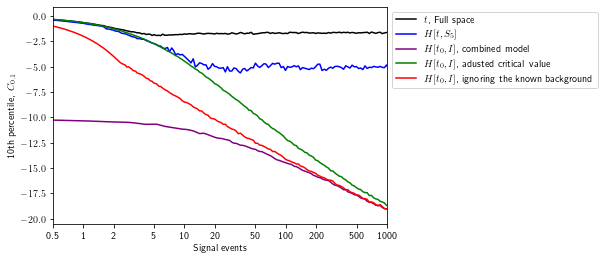

In [3]:
for s in statistics.values():
    y = s['stat'].dist.ppf(0.1, rate=mu_signal)
    plt.plot(mu_signal, y, label=s['label'], color=s['color'])

# s = statistics['lr0_s5_sigmu']['stat'].with_stored_dist(
#     'lr_s5_sigmu_powerlaw_0.500_20.000',
#     n_toys=100)
# plt.plot(mu_signal, s.dist.ppf(0.1, rate=mu_signal), color='darkorange')

plt.xlabel("Signal events")
log_x(0.5, 1000)

plt.ylabel("10th percentile, $C_{0.1}$")

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

In [4]:
similarities = np.linspace(-1, 1, 14)

# high_bg = True
# if high_bg:
#     mu_bgs = np.geomspace(100, 1000, 5)[1:]
# else:
mu_bgs = np.geomspace(1, 100, 10)
#total_limits = s['n_toy_limits'] * mu_bgs.size * similarities.size

cache_folder = Path('./limits_mixedbg/')
cache_folder.mkdir(exist_ok=True)

def draw_all_limits(similarity, *, s):
    results = np.zeros((len(mu_bgs), s['n_toy_limits']))
    for mu_i, mu_bg in enumerate(mu_bgs):

        unknown_bg = powerlaw(similarity, mu_bg).freeze()

        # Get toy limits
        anchors = (mu_signal_clip if isinstance(s['stat'], hp.YellinCNHawk) else mu_signal)
        #print(s['stat'], anchors)
        ul = hp.UpperLimit(s['stat'], anchors=anchors.tolist(), )
        results[mu_i] = draw_limits(ul, known_bg + unknown_bg, s['n_toy_limits'], 
                                    tolerant=False
                                   )
    return results

In [5]:
for stat_name, s in statistics.items():
    print(stat_name)

    limits_fn = cache_folder / f'{stat_name}_{len(similarities)}_{len(mu_bgs)}_{s["n_toy_limits"]}{suffix}.pkl.gz'
    if limits_fn.exists():
        with gzip.open(limits_fn, mode='rb') as f:
            s['limits'] = pickle.load(f)
    else:    
        t_start = time.monotonic()
        with ProcessPoolExecutor(max_workers=min(7, len(similarities))) as exc:
            s['limits'] = np.stack(list(exc.map(
                partial(draw_all_limits, s=s), 
                similarities)))
        t_end = time.monotonic()
        print(f"{stat_name} took {t_end - t_start:.1f} sec")
            
        with gzip.open(limits_fn, mode='wb') as f:
            pickle.dump(s['limits'], f)
            
for statname, s in statistics.items():
    s['sensitivity'] = np.nanmean(s['limits'], axis=2)

full_lr
s5_lr
lr0_all
lr0_all_sigmu
lr0_all_ignore_bg


In [6]:
# Reorder similarities: go from 0 to 1 first, then -1 to 0. 
# Ignore -1 itself; it's the same dist as similarity = 1
reor = np.concatenate([
    np.where(similarities > 0)[0],
    np.where(similarities < 0)[0][1:]])
sim_reor = similarities[reor]
sim_reor_proxy = np.linspace(-1, 1, len(reor))
sim_reor

array([ 0.07692308,  0.23076923,  0.38461538,  0.53846154,  0.69230769,
        0.84615385,  1.        , -0.84615385, -0.69230769, -0.53846154,
       -0.38461538, -0.23076923, -0.07692308])

/tmp/ipykernel_29755/3983602360.py:24: UserWarning: No contour levels were found within the data range.
  plt.contour(mu_bgs, sim_reor_proxy, z[reor,:],


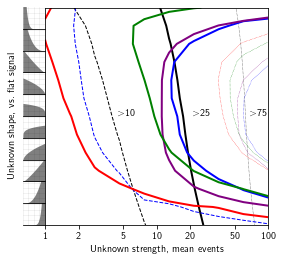

In [7]:
levels, linestyles, linewidths = np.array([10, 25, 75]), ['--', '-', ':'], [1, 2, 0.5]
lw = 1



fig = plt.figure(figsize=(4,4))

for statname, s in statistics.items():
    s['sensitivity'] = np.nanmean(s['limits'], axis=2)
    
for statname, s in statistics.items():
    color = s['color']

    for level, linestyle, lw in zip(levels, linestyles, linewidths):
#         if True: #statname == 'full_lr':
#             # Has discontinuity at similarity = 0 -> now moved
#             masks = (sim_reor > 0, similarities < 0)
#         else:
        #masks = (np.isfinite(similarities),)

        z = s['sensitivity']
            
        #for mask in masks:
        plt.contour(mu_bgs, sim_reor_proxy, z[reor,:],
        #plt.contour(mu_bgs, similarities, y,
                    levels=[level],
                    norm=matplotlib.colors.LogNorm(1, 100),
                    linewidths=lw,
                    linestyles=linestyle,
                    colors=[color])
    # Null line plot, so legend has something
    plt.plot([0], [0], 
             label=s.get('label', statname), 
             linestyle='-',
             color=color,
             linewidth=lw) 

# ypos = 1.05
# for i, l in enumerate(levels):
#     xpos = np.exp(np.interp(np.log(l), 
#                             np.log(statistics['full_lr']['sensitivity'][-1]), 
#                             np.log(mu_bgs)))
#     plt.text(xpos, ypos, f'> {l}')
#     if i == 0:
#         plt.text(xpos, ypos, f'Mean limit ', ha='right')

#plt.scatter([20], [0.5], c='purple', marker='D', label='Known background')
        
# legend = plt.legend(
#     loc='upper left',
#     bbox_to_anchor=(1.218, 1.05),
#     labelspacing=0.8,
#     frameon=False,)

#plt.ylabel("Similarity to signal")
plt.ylabel("Unknown shape, vs. flat signal", labelpad=29)
plt.ylim(-1, 1)
plt.yticks([])
# plt.yticks([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1],
#            ['1', '0.75', '0.5', '0.25', '0', '0.25', '0.5', '0.75', '1'])

plt.xlabel("Unknown strength, mean events")
log_x(1, 100 + 1e-9, tick_at=[1, 2, 5])
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))

# Alt limit labels
for i, xloc in enumerate([5.35, 25, 80]):
    plt.text(xloc, 0, "$>$" + str(levels[i]), ha='center', fontsize=10)

# Add dist sketches
n_sketch = 10
width = 0.1
#xpos = 0.91
xpos = 0.048
sketch_sims = np.linspace(-1, 1, n_sketch + 2)[1:-1]
y_start = 0.125  # y matching lower spine
y_end = 0.882    # y matching upper spine
width = (y_end - y_start) / n_sketch
sketch_sims_reor = np.concatenate(
    [sketch_sims[n_sketch//2:], sketch_sims[:n_sketch//2]])
for i, sim in enumerate(sketch_sims_reor):
    plt.sca(fig.add_axes([xpos, y_start + i * width, 
                          width, width]))
    sketch_dist(powerlaw(sim, 1), xlabel=None)


for fmt in 'png', 'pdf':
    min_toy_limits = min([s['n_toy_limits'] for s in statistics.values()])
    plt.savefig(f'statscomp_mixedbg_{min_toy_limits}{suffix}.{fmt}',
                dpi=200, bbox_inches='tight')
plt.show()